['201011_MERGE', '201012_MERGE', '201101_MERGE', '201102_MERGE', '201103_MERGE', '201104_MERGE', '201105_MERGE', '201106_MERGE', '201107_MERGE', '201108_MERGE', '201109_MERGE', '201110_MERGE', '201111_MERGE', '201112_MERGE', '201201_MERGE', '201202_MERGE', '201203_MERGE', '201204_MERGE', '201205_MERGE', '201206_MERGE', '201207_MERGE', '201208_MERGE', '201209_MERGE', '201210_MERGE', '201211_MERGE', '201212_MERGE', '201301_MERGE', '201302_MERGE', '201303_MERGE', '201304_MERGE', '201305_MERGE', '201306_MERGE', '201307_MERGE', '201308_MERGE', '201309_MERGE', '201310_MERGE', '201311_MERGE', '201312_MERGE', '201401_MERGE', '201402_MERGE', '201403_MERGE', '201404_MERGE', '201405_MERGE', '201406_MERGE', '201407_MERGE', '201408_MERGE', '201409_MERGE', '201410_MERGE', '201411_MERGE', '201412_MERGE', '201501_MERGE', '201502_MERGE', '201503_MERGE', '201504_MERGE', '201505_MERGE', '201506_MERGE', '201507_MERGE', '201508_MERGE', '201509_MERGE', '201510_MERGE', '201511_MERGE', '201512_MERGE', '201601

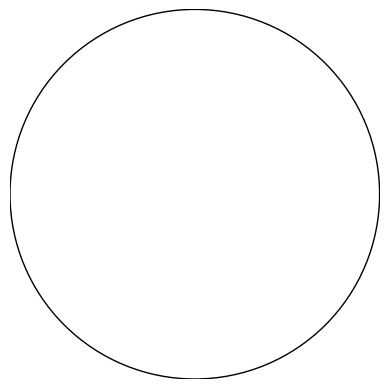

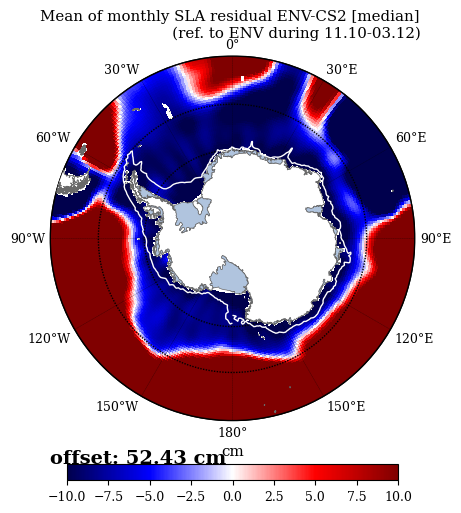

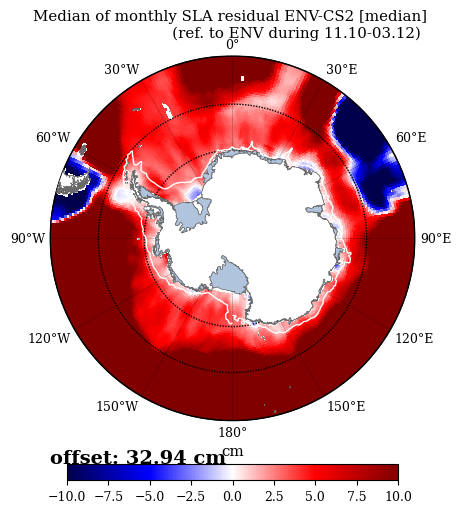

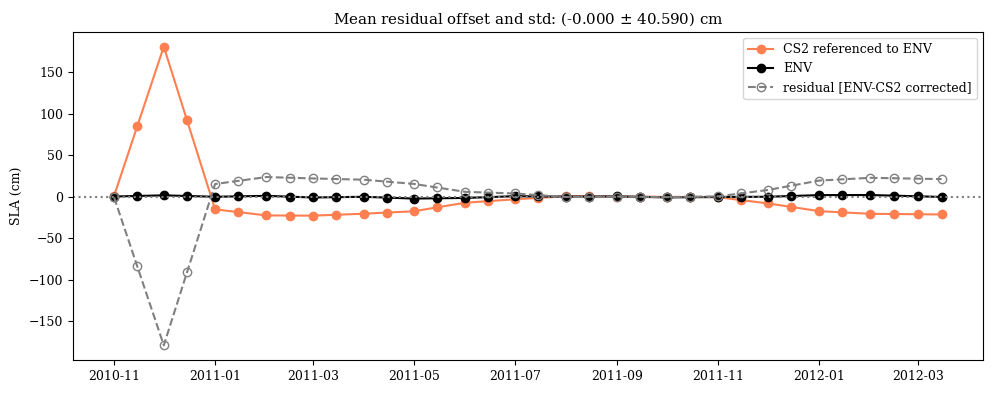

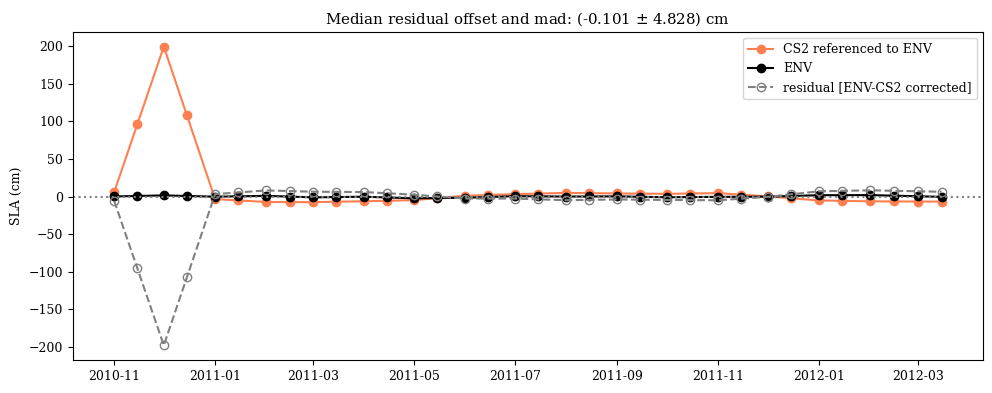

In [1]:
#ch3
"""
Compute SLA referenced to the ENV_MDT overlap period.


Last modified: 31 Mar 2021
"""

import numpy as np
from numpy import ma

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.ticker import FormatStrFormatter
import matplotlib

from palettable.colorbrewer.diverging import RdBu_11, PuOr_11

import xarray as xr
import pandas as pd

import sys

#----------------------------------------------------------
# Define directories
voldir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/'
griddir = voldir + 'altimetry_cpom/3_grid_dot/'
lmdir = voldir + 'land_masks/'
figdir = voldir + '../PhD_figures/Figures_v8/'

scriptdir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_scripts/'
auxscriptdir = scriptdir + '/aux_func/'

sys.path.append(auxscriptdir)
from aux_1_filenames import cs2_id_list as filenames
import aux_func as ft


sys.path.append(auxscriptdir)
import aux_func as fc
import aux_stereoplot as st

#----------------------------------------------------------

# Intersatellite offset (median, metres)
#intersat_off = 0.041465 # for SLA (SSH-geoid); filt sigma=2 grid cells
#intersat_off = 0.041638 # filter sigma=1 grid cell
#intersat_off = 0.041194 # for SSHA (SSH-MSS)
# 7, sigma=2
#intersat_off = 0.037405
#7, sigma=3
#intersat_off = 0.037129

# 3 may 2020:
#intersat_off = 0.03712

#----------------------------------------------------------

# # # # # # # # # # # #
geoidtype = '_goco05c'#'_eigen6s4v2_neg' #'_egm2008' #'_goco05c'
statistics = 'median'
# # # # # # # # # # # #

cs2_file = griddir + '2week_dot_cs2_30b' + statistics + geoidtype + '_sig3.nc'
env_file = griddir + '2week_dot_env_30b' + statistics + geoidtype + '_sig3.nc'

with xr.open_dataset(cs2_file) as cs2_dict:
    print(cs2_dict.keys())
with xr.open_dataset(env_file) as env_dict:
    print(env_dict.keys())

# overlap period
time = pd.date_range('2010-11-01', '2012-03-01', freq='1MS')

# overlap period - 2 weeks avg
time_start = pd.date_range('2010-11-01', '2012-03-01', freq='1MS')
time_mid = time_start + timedelta(days=14)
time = time_start.append(time_mid).sort_values()


env = env_dict.sel(time=slice(time[0], time[-1]))
cs2 = cs2_dict.sel(time=slice(time[0], time[-1]))

print(env.keys())
print(cs2.keys())

# LAT/LON GRID
lat = env.latitude.values
lon = env.longitude.values
elat = env.edge_lat.values
elon = env.edge_lon.values

eglat, eglon = np.meshgrid(elat, elon)

lmask = env.land_mask.values

#----------------------------------------------------------
# OVERLAP PERIOD SLA OFFSET
#----------------------------------------------------------
itt = len(time)

cs2_mdt = cs2.dot.mean('time')
env_mdt = env.dot.mean('time')

cs2_sla = cs2.dot - env_mdt
env_sla = env.dot - env_mdt

# # # # # # # # # # # #
# SLA residual - time series of maps
sla_dif = env_sla - cs2_sla

# map of mean/median residual
sla_dif_median = sla_dif.median("time").values
sla_dif_mean = sla_dif.mean("time").values

#----------------------------------------------------------
# area-weighted circumpolar SLA average - time series
#----------------------------------------------------------
area_grid = fc.grid_area(eglon, eglat)
area_grid[lmask==1] = np.nan # mask where land

# mask cells where the offset is negative
res_median = sla_dif_median.copy()
res_mean = sla_dif_mean.copy()

res_median[res_median<0] = np.nan
res_mean[res_mean<0] = np.nan

# area weighted average
a1 = res_mean*area_grid
a2 = res_median*area_grid

area1_sum = np.nansum(area_grid[~np.isnan(a1)])
area2_sum = np.nansum(area_grid[~np.isnan(a2)])

avg_off1 = np.nansum(a1)/area1_sum
avg_off2 = np.nansum(a2)/area2_sum

print("mean area weighted avg: %s (m)" % avg_off1)
print("median area weighted avg: %s (m)" % avg_off2)

#----------------------------------------------------------
#           PLOT of mean/median of RESIDUAL
#----------------------------------------------------------
cbar_range = [-10, 10]
cbar_units = 'cm'
cmap = cm.seismic

# # # # # # # # # # # #
fig, ax, m = st.spstere_plot(eglon, eglat, sla_dif_mean*1e2,
                cbar_range, cmap, cbar_units, 'w')
fig.tight_layout(rect=[0, -.1, 1, .95])
fig.suptitle(('{}').format('Mean of monthly SLA residual ENV-CS2 [%s] \n\
                           (ref. to ENV during 11.10-03.12)' % statistics))
ax.annotate('offset: %.2f cm' % (avg_off1*1e2),
    xy=(.1,.1),
    xycoords='figure fraction',
    weight='bold', fontsize=14)


# # # # # # # # # # # #

fig, ax, m = st.spstere_plot(eglon, eglat, sla_dif_median*1e2,
                cbar_range, cmap, cbar_units, 'w')
fig.tight_layout(rect=[0, -.1, 1, .95])
fig.suptitle(('{}').format('Median of monthly SLA residual ENV-CS2 [%s] \n\
                           (ref. to ENV during 11.10-03.12)' % statistics))
ax.annotate('offset: %.2f cm' % (avg_off2*1e2),
    xy=(.1,.1),
    xycoords='figure fraction',
    weight='bold', fontsize=14)

#sys.exit()
# stop here


# # # # # # # # # # # #
# # save in a file
# offset = xr.Dataset({'mean_map' : (('longitude', 'latitude'), sla_dif_mean),
#                     'median_map' : (('longitude', 'latitude'), sla_dif_median),
#                     'mean_aw_avg' : avg_off1,
#                     'median_aw_avg' : avg_off2},
#                     coords={'longitude' : lon,
#                     'latitude' : lat})
# offset.to_netcdf(griddir + 'intersat_off_b' + statistics + '.nc')

# A. correct CS2 SLA with the aw avg of the mean in every cell
# - - - - - - - - - - - - - - - - - - - -
cs2_sla_v = cs2_sla.values + avg_off1
env_sla_v = env_sla.values

# and compare area-weighted averaged time series
env_sla_v[sla_dif_mean<0] = np.nan
cs2_sla_v[sla_dif_mean<0] = np.nan

# - - - - - - - - - - - - - - - - - - - -
# area-weighted avg and residual
avg_sla_cs2, avg_sla_env = [ma.ones((itt, )) for _ in range(2)]
for i in range(itt):
    aa = ma.masked_invalid(cs2_sla_v[:, :, i]*area_grid)
    total_area = ma.sum(area_grid[~aa.mask])
    avg_sla_cs2[i] = ma.sum(aa)/total_area

    bb = ma.masked_invalid(env_sla_v[:, :, i]*area_grid)
    total_area = ma.sum(area_grid[~bb.mask])
    avg_sla_env[i] = ma.sum(bb)/total_area

# difference between satellites; mean and median of time series
overlap_median = ma.median(avg_sla_env - avg_sla_cs2)
overlap_mad = ma.median(abs((avg_sla_env-avg_sla_cs2)-overlap_median))

overlap_mean = ma.mean(avg_sla_env - avg_sla_cs2)
overlap_std = ma.std(avg_sla_env-avg_sla_cs2, ddof=1)

print("Envisat - CS2 offset (cm) ")
print("median: %.4f + %.4f cm" %(overlap_median*1e2,
                                 overlap_mad*1e2))
print("  mean: %.4f + %.4f cm" %(overlap_mean*1e2,
                                 overlap_std*1e2))

#----------------------------------------------------------

plt.ion()
fig, ax =  plt.subplots(figsize=(10, 4))
x = time
ax.plot(x, (avg_sla_cs2)*1e2,
        c='coral', marker='o',
        label='CS2 referenced to ENV')
ax.plot(x, avg_sla_env*1e2, c='k',
        marker='o',
        label='ENV')
ax.plot(x, (avg_sla_env-avg_sla_cs2)*1e2,
        c='grey', ls='--',
        marker='o', markerfacecolor='none',
        label='residual [ENV-CS2 corrected]')
ax.axhline(0, ls=':', c='grey')
ax.legend()
ax.set_ylabel("SLA (cm)")
ax.set_title(r"Mean residual offset and std: (%.3f $\pm$ %.3f) cm"
             % (overlap_mean*1e2, overlap_std*1e2))
plt.tight_layout()

#----------------------------------------------------------
#----------------------------------------------------------
# A. correct CS2 SLA with the aw avg of the median in every cell
# - - - - - - - - - - - - - - - - - - - -
cs2_sla_v = cs2_sla.values + avg_off2
env_sla_v = env_sla.values

# and compare area-weighted averaged time series
env_sla_v[sla_dif_median<0] = np.nan
cs2_sla_v[sla_dif_median<0] = np.nan

# - - - - - - - - - - - - - - - - - - - -
# area-weighted avg and residual
avg_sla_cs2, avg_sla_env = [ma.ones((itt, )) for _ in range(2)]
for i in range(itt):
    aa = ma.masked_invalid(cs2_sla_v[:, :, i]*area_grid)
    total_area = ma.sum(area_grid[~aa.mask])
    avg_sla_cs2[i] = ma.sum(aa)/total_area

    bb = ma.masked_invalid(env_sla_v[:, :, i]*area_grid)
    total_area = ma.sum(area_grid[~bb.mask])
    avg_sla_env[i] = ma.sum(bb)/total_area

# difference between satellites; mean and median of time series
overlap_median = ma.median(avg_sla_env - avg_sla_cs2)
overlap_mad = ma.median(abs((avg_sla_env-avg_sla_cs2)-overlap_median))

overlap_mean = ma.mean(avg_sla_env - avg_sla_cs2)
overlap_std = ma.std(avg_sla_env-avg_sla_cs2, ddof=1)

print("Envisat - CS2 offset (cm) ")
print("median: %.4f + %.4f cm" %(overlap_median*1e2,
                                 overlap_mad*1e2))
print("  mean: %.4f + %.4f cm" %(overlap_mean*1e2,
                                 overlap_std*1e2))

#----------------------------------------------------------

plt.ion()
fig, ax =  plt.subplots(figsize=(10, 4))
x = time
ax.plot(x, (avg_sla_cs2)*1e2,
        c='coral', marker='o',
        label='CS2 referenced to ENV')
ax.plot(x, avg_sla_env*1e2, c='k',
        marker='o',
        label='ENV')
ax.plot(x, (avg_sla_env-avg_sla_cs2)*1e2,
        c='grey', ls='--',
        marker='o', markerfacecolor='none',
        label='residual [ENV-CS2 corrected]')
ax.axhline(0, ls=':', c='grey')
ax.legend()
ax.set_ylabel("SLA (cm)")
ax.set_title(r"Median residual offset and mad: (%.3f $\pm$ %.3f) cm"
             % (overlap_median*1e2, overlap_mad*1e2))
plt.tight_layout()

#----------------------------------------------------------

# save a mask with 1s where the offset > 0 and 0 everywhere else - commented this as msla not a vairbale
# dif_mask = ma.ones((msla_dif.shape))
# dif_mask[msla_dif.mask==True] = ma.masked
# dif_mask[msla_dif<0]=0
# lo, la = dif_mask.shape
# elo, ela = len(elon), len(elat)

sla_dif_ma = ma.masked_invalid(sla_dif.values)
dif_mask = ma.ones((sla_dif.shape))
dif_mask[sla_dif_ma.mask==True] = ma.masked
dif_mask[sla_dif_ma<0]=0

lo, la, time = dif_mask.shape
elo, ela = len(elon), len(elat)

plt.show()





